In [1]:
import importlib

import dataset, metrics, plotting, config
from models import cgan_model
import numpy as np
import random

importlib.reload(dataset)
importlib.reload(metrics)
importlib.reload(plotting)
importlib.reload(config)
importlib.reload(cgan_model)

Using TensorFlow backend.
/Users/zhongsheng/anaconda2/envs/ganRegression/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/zhongsheng/anaconda2/envs/ganRegression/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/zhongsheng/anaconda2/envs/ganRegression/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16",

<module 'models.cgan_model' from '/Users/zhongsheng/Documents/GitWorkspace/ganRegression/models/cgan_model.py'>

In [2]:
import os

dataset_config = config.DatasetConfig(scenario="magical_sinus", n_instance=250)

assert(dataset_config.scenario == "magical_sinus"
       or dataset_config.scenario == "hdpe"
      )
fig_dir = f"../figures/{dataset_config.scenario}"

try:
    os.mkdir(fig_dir)
    print(f"Directory {fig_dir} created ") 
except FileExistsError:
    print(f"Directory {fig_dir} already exists replacing files in this notebook")

Directory ../figures/magical_sinus already exists replacing files in this notebook


In [3]:
exp_config = config.Config(
    model=config.ModelConfig(activation="elu", lr_gen=0.0001, lr_disc=0.001, optim_gen="Adam",
                             optim_disc="Adam", z_input_size=5),
    training=config.TrainingConfig(n_epochs=10000, batch_size=100, n_samples=500),
    dataset=dataset_config,
    run=config.RunConfig(save_fig=1)
)

In [4]:
# Set random seed
np.random.seed(exp_config.model.random_seed)
random.seed(exp_config.model.random_seed)

from tensorflow import set_random_seed
set_random_seed(exp_config.model.random_seed)

In [5]:
X_train, y_train, _, _ = dataset.get_dataset(exp_config.dataset.n_instance, exp_config.dataset.scenario)

## Gaussian Process 

In [6]:
import GPy

noise = 4.3
length = 16

run_hyperopt_search = True

kernel = GPy.kern.RBF(input_dim=2, variance=noise, lengthscale=length)
gpr = GPy.models.GPRegression(X_train, y_train, kernel)
if run_hyperopt_search:
    gpr.optimize(messages=True)

 /Users/zhongsheng/anaconda2/envs/ganRegression/lib/python3.6/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/zhongsheng/anaconda2/envs/ganRegression/lib/python3.6/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/zhongsheng/anaconda2/envs/ganRegression/lib/python3.6/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


## Construct CGAN model

In [7]:
cgan = cgan_model.CGAN(exp_config)
d_loss_err, d_loss_true, d_loss_fake, g_loss_err, g_pred, g_true = cgan.train(X_train, y_train, 
                                                                              epochs=exp_config.training.n_epochs,
                                                                              batch_size=exp_config.training.batch_size,
                                                                              verbose=False)







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "Generator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Generator_input_x (InputLayer)  (None, 2)            0                                            
__________________________________________________________________________________________________
Generator_input_z (InputLayer)  (None, 5)            0                                            
__________________________________________________________________________________________________
dense_7 (Dense)                 (None, 20)           60          Generator_input_x[0][0]          
__________________________________________________________________________________________________
dense_8 (Dense)                 (None, 20)           120         Generator_input_z[0][0] 

 /Users/zhongsheng/anaconda2/envs/ganRegression/lib/python3.6/site-packages/keras/engine/training.py:493: UserWarning:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


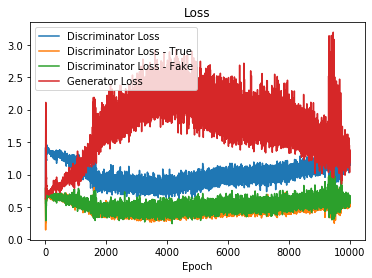

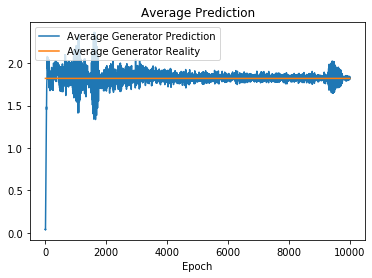

In [8]:
plotting.plots(d_loss_err, d_loss_true, d_loss_fake, g_loss_err, g_pred, g_true, fig_dir, exp_config.run.save_fig)

## CVT samples: taking as input parts of a paired virtual  samples.

In [9]:
from os.path import basename
X_CVT = np.load(f"{fig_dir}/{basename(fig_dir)}_CVT_samples.npy")

In [10]:
from dataset import _magical_sinus
y = _magical_sinus(X_CVT[:,0], X_CVT[:,1]).reshape(-1, 1)

In [11]:
ypred_single_cgan_cvt = cgan.predict(X_CVT)
ypred_mean_cgan_cvt, _, _ = cgan.sample(X_CVT, exp_config.training.n_samples)
ypred_gp_cvt, cov_cvt = gpr.predict(X_CVT)

## Predictions

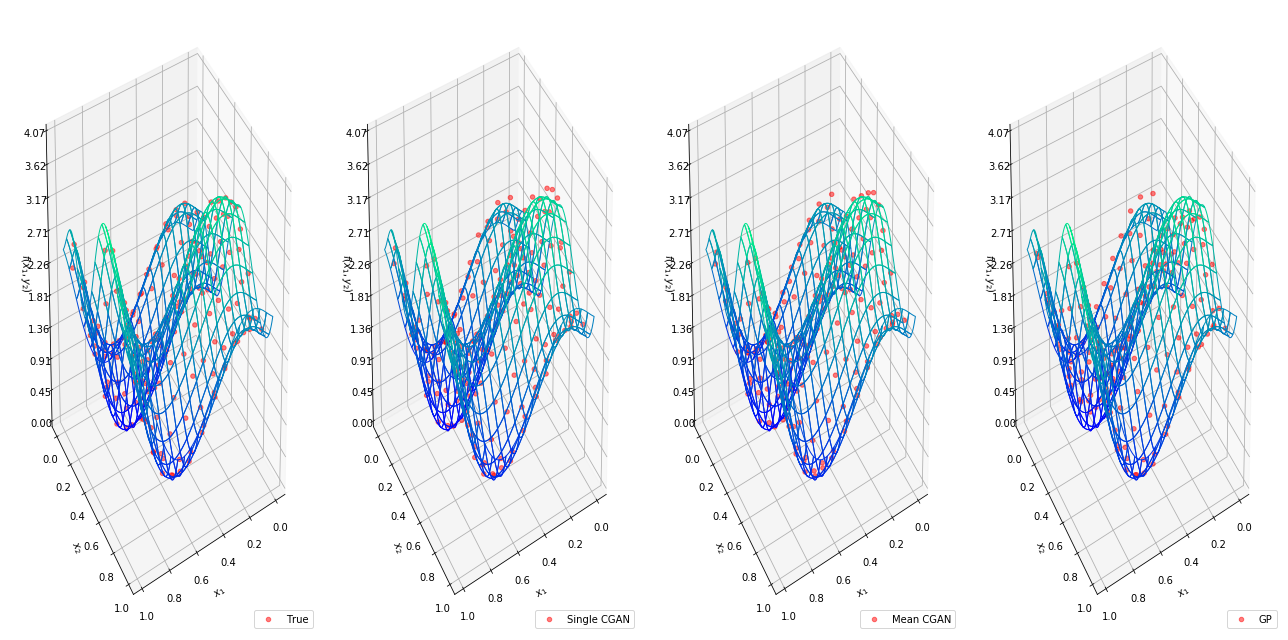

In [12]:
# Predictions using single or mean of CGAN along with GP
plotting.plot_ypred_joint(X_CVT, y, ypred_single_cgan_cvt, ypred_mean_cgan_cvt, ypred_gp_cvt,
                          fig_dir=fig_dir, prefix="single_mean_cgan_gp", save_fig=exp_config.run.save_fig,
                          alpha=0.5, elevation=30, azimuth=60)

## Marginalized density of P(y)

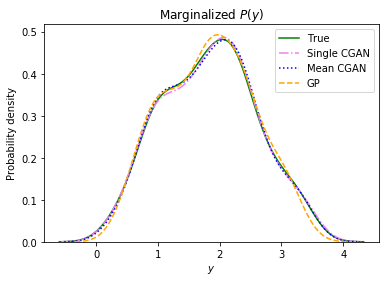

In [13]:
plotting.plot_densities_joint(y, ypred_single_cgan_cvt, ypred_mean_cgan_cvt, ypred_gp_cvt,
                              title=r"Marginalized $P(y)$", fig_dir=fig_dir,
                              prefix="marginalized_P(y)", save_fig=exp_config.run.save_fig)

## Sampling from P(y|x)

In [14]:
num_sampling = 200 # increase sample_size to have gaussian densities for GP
ypred_mean_cgan, _, ypred_mean_cgan_sampling = cgan.sample(X_CVT, num_sampling)

ypred_gp, cov = gpr.predict(X_CVT)
ypred_gp_sampling = np.random.normal(ypred_gp, np.sqrt(cov))
for i in range(1, num_sampling):
    ypred_gp_sampling = np.hstack([ypred_gp_sampling, np.random.normal(ypred_gp, np.sqrt(cov))])

ypred_single_cgan_sampling = cgan.predict(X_CVT)
for i in range(1, num_sampling):
    ypred_single_cgan_sampling = np.hstack([ypred_single_cgan_sampling, cgan.predict(X_CVT)])


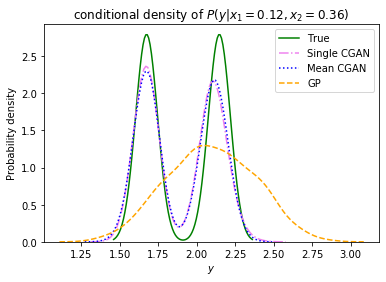

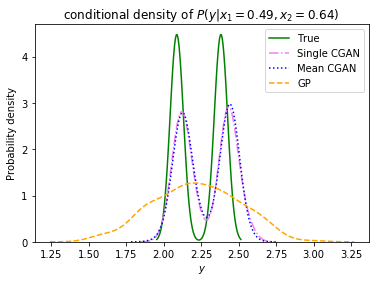

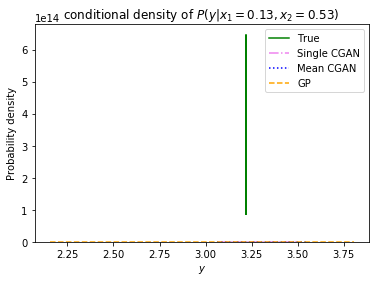

In [38]:
bins =[[0.12, 0.36], [0.49, 0.64], [0.13, 0.53]]
for (x1, x2) in bins:
    y_true = dataset.get_true_y_given_x(given_x1=x1, given_x2=x2,
                                        X=np.tile(X_CVT, (num_sampling, 1)),
                                        y=np.tile(y, (num_sampling, 1)))

    ypred_single_cgan_cond = dataset.get_true_y_given_x(given_x1=x1, given_x2=x2,
                                        X=np.tile(X_CVT, (num_sampling, 1)),
                                        y=np.ravel(ypred_single_cgan_sampling.T).reshape(-1, 1))

    ypred_mean_cgan_cond = dataset.get_true_y_given_x(given_x1=x1, given_x2=x2,
                                        X=np.tile(X_CVT, (num_sampling, 1)),
                                        y=np.ravel(ypred_mean_cgan_sampling.T).reshape(-1, 1))

    ypred_gp_cond = dataset.get_true_y_given_x(given_x1=x1, given_x2=x2,
                                        X=np.tile(X_CVT, (num_sampling, 1)),
                                        y=np.ravel(ypred_gp_sampling.T).reshape(-1, 1))

    (y_true, ypred_mean_cgan_cond, ypred_gp_cond) = (y_true.reshape(-1, 1),
                                                      ypred_mean_cgan_cond.reshape(-1, 1),
                                                      ypred_gp_cond.reshape(-1, 1))

#     plotting.plot_densities_joint(y_true.reshape(-1,1),
#                                   ypred_single_cgan_cond.reshape(-1, 1),
#                                   ypred_mean_cgan_cond.reshape(-1, 1),
#                                   ypred_gp_cond.reshape(-1, 1),
#                                   title = f"conditional density of $P(y|x_1={x1},x_2={x2})$ ", fig_dir=fig_dir,
#                                   prefix=f"condition_density_P(y|x1={x1},x2={x2})", save_fig=exp_config.run.save_fig)
    plotting.plot_densities_joint(y_true.reshape(-1,1),
                                      ypred_single_cgan_cond.reshape(-1, 1),
                                      ypred_mean_cgan_cond.reshape(-1, 1),
                                      ypred_gp_cond.reshape(-1, 1),
                                      title = f"conditional density of $P(y|x_1={x1},x_2={x2})$ ", fig_dir=fig_dir,
                                      prefix=f"condition_density_P(y|x1={x1},x2={x2})", save_fig=False)




## Metrics on validation samples

In [16]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

single_cgan_mae_list = []
single_cgan_mse_list= []

mean_cgan_mae_list = []
mean_cgan_mse_list = []

gp_mae_list = []
gp_mse_list =[]

n_eval_runs = 50
for i in range(n_eval_runs):
    ypred_single_cgan = cgan.predict(X_CVT)
    single_cgan_mae_list.append(mean_absolute_error(y, ypred_single_cgan))
    single_cgan_mse_list.append(mean_squared_error(y, ypred_single_cgan))

    ypred_mean_cgan, _, _ = cgan.sample(X_CVT, exp_config.training.n_samples)
    mean_cgan_mae_list.append(mean_absolute_error(y, ypred_mean_cgan))
    mean_cgan_mse_list.append(mean_squared_error(y, ypred_mean_cgan))

    yped_gp = np.random.normal(ypred_gp_cvt, np.sqrt(cov_cvt))
    gp_mae_list.append(mean_absolute_error(y, yped_gp))
    gp_mse_list.append(mean_squared_error(y, yped_gp))


In [17]:
single_cgan_mae_mean, single_cgan_mae_std = np.mean(np.asarray(single_cgan_mae_list)), np.std(np.asarray(single_cgan_mae_list))
single_cgan_mse_mean, single_cgan_mse_std = np.mean(np.asarray(single_cgan_mse_list)), np.std(np.asarray(single_cgan_mse_list))

print(f"Single CGAN validation MAE: {single_cgan_mae_mean:.3f} +- {single_cgan_mae_std:.5f}")
print(f"Single CGAN validation MSE: {single_cgan_mse_mean:.3f} +- {single_cgan_mse_std:.5f}")

mean_cgan_mae_mean, mean_cgan_mae_std = np.mean(np.asarray(mean_cgan_mae_list)), np.std(np.asarray(mean_cgan_mae_list))
mean_cgan_mse_mean, mean_cgan_mse_std = np.mean(np.asarray(mean_cgan_mse_list)), np.std(np.asarray(mean_cgan_mse_list))

print(f"Mean CGAN validation MAE: {mean_cgan_mae_mean:.3f} +- {mean_cgan_mae_std:.5f}")
print(f"Mean CGAN validation MSE: {mean_cgan_mse_mean:.3f} +- {mean_cgan_mse_std:.5f}")

gp_mae_mean, gp_mae_std = np.mean(np.asarray(gp_mae_list)), np.std(np.asarray(gp_mae_list))
gp_mse_mean, gp_mse_std = np.mean(np.asarray(gp_mse_list)), np.std(np.asarray(gp_mse_list))
print(f"GP validation MAE: {gp_mae_mean:.3f} +- {gp_mae_std:.5f}")
print(f"GP validation MSE: {gp_mse_mean:.3f} +- {gp_mse_std:.5f}")

Single CGAN validation MAE: 0.067 +- 0.00331
Single CGAN validation MSE: 0.008 +- 0.00077
Mean CGAN validation MAE: 0.047 +- 0.00025
Mean CGAN validation MSE: 0.004 +- 0.00003
GP validation MAE: 0.233 +- 0.01266
GP validation MSE: 0.086 +- 0.00848


In [18]:
nlpd_list = []
for i in range(n_eval_runs):
    nlpd_list.append(metrics.gaussian_NLPD(y, np.random.normal(ypred_gp_cvt, np.sqrt(cov_cvt)), cov_cvt))
gp_nlpd_mean = np.mean(nlpd_list)
gp_nlpd_std = np.std(nlpd_list)
print(f"GP validation NLPD: {gp_nlpd_mean:.3f} +- {gp_nlpd_std:.5f}")

GP validation NLPD: 0.250 +- 0.07093


In [19]:
nlpd_list = []
for i in range(n_eval_runs):
    ypred_single_cgan_cvt = cgan.predict(X_CVT)
    cov = np.ones(len(ypred_single_cgan_cvt))* np.mean((y - ypred_single_cgan_cvt)**2)
    nlpd_list.append(metrics.gaussian_NLPD(y, ypred_single_cgan_cvt, cov))
single_cgan_nlpd_mean = np.mean(nlpd_list)
single_cgan_nlpd_std = np.std(nlpd_list)
print(f"Single CGAN Validation NLPD: {single_cgan_nlpd_mean:.3f} +- {single_cgan_nlpd_std:.5f}")

Single CGAN Validation NLPD: -1.012 +- 0.04945


In [20]:
_, w, _ = metrics.Parzen(cgan, X_train, y_train)
nlpd_list = []
for i in range(n_eval_runs):
    nlpd_list.append(metrics.Parzen_test(cgan, X_CVT, y, w, exp_config.training.n_samples))
mean_cgan_nlpd_mean = np.mean(nlpd_list)
mean_cgan_nlpd_std = np.std(nlpd_list)
print(f"Mean CGAN Validation NLPD: {mean_cgan_nlpd_mean:.3f} +- {mean_cgan_nlpd_std:.5f}")

Mean CGAN Validation NLPD: -1.297 +- 0.00319


In [21]:
if exp_config.run.save_fig:

    try:
        file = open(f"{fig_dir}/metrics_on_CVT.txt","w")
    except FileExistsError:
        print(f" {fig_dir} was failed to create.")

    file.write(f"===Validation MAE===\n")
    file.write(f"GP validation MAE: {gp_mae_mean} +- {gp_mae_std}\n")
    file.write(f"Single CGAN validation MAE: {single_cgan_mae_mean} +- {single_cgan_mae_std}\n")
    file.write(f"Mean CGAN validation MAE: {mean_cgan_mae_mean} +- {mean_cgan_mae_std}\n")
    file.write(f"===Validation MSE===\n")
    file.write(f"GP validation MSE: {gp_mse_mean} +- {gp_mse_std}\n")
    file.write(f"Single CGAN validation MSE: {single_cgan_mse_mean} +- {single_cgan_mse_std}\n")
    file.write(f"CGAN validation MSE: {mean_cgan_mse_mean} +- {mean_cgan_mse_std}\n")
    file.write(f"===Validation NLPD===\n")
    file.write(f"GP Gaussian NLPD: {gp_nlpd_mean} +- {gp_nlpd_std}\n")
    file.write(f"Single CGAN NLPD: {single_cgan_nlpd_mean} +- {single_cgan_nlpd_std}\n")
    file.write(f"Mean CGAN NLPD: {mean_cgan_nlpd_mean} +- {mean_cgan_nlpd_std}\n")
    file.close()
